In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [14]:
def plot_plane(a, b, c, d, x1, y1, z1, x2, y2, z2, x3, y3, z3, export = False):
    x, y = np.linspace(-2, 2, 100), np.linspace(-2, 2, 100)
    X, Y = np.meshgrid(x, y)
    Z = (-d - a * X - b * Y) / c
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z)

    ax.plot(x1, y1, z1, "ro")
    ax.plot(x2, y2, z2, "ro")
    ax.plot(x3, y3, z3, "ro")

    if export :
        plt.savefig("plane.png")
    
    else :
        plt.show()

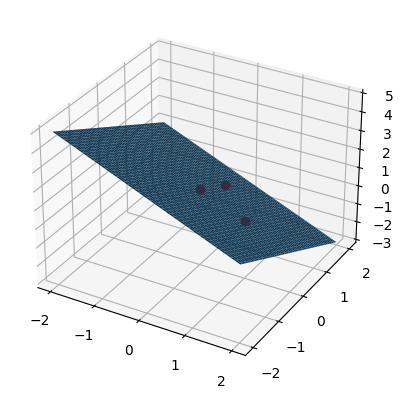

In [15]:
a, b, c, d = 1, 1, 1, -1
x1, y1, z1 = (1, 0, 0)
x2, y2, z2 = (0, 1, 0)
x3, y3, z3 = (0, 0, 1)

plot_plane(a, b, c, d, x1, y1, z1, x2, y2, z2, x3, y3, z3)